In [1]:
# ==============================
# Standard Library Imports
# ==============================
from enum import Enum
import random

# ==============================
# Third-party Library Imports
# ==============================
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from matplotlib.ticker import MultipleLocator
import numpy as np  # Original numpy
import pennylane as qml
import torch 

# ==============================
# User defined 
# ==============================
import plot_data as pt
import torch_optimizer as tr_opt

In [2]:
# ==============================
# Setup for Quantum Computations
# ==============================

# PennyLane settings
dev = qml.device('default.mixed', wires=1)

# Define Hamiltonian for quantum computations
H = qml.Hamiltonian(coeffs = [-0.5], observables=[qml.PauliZ(0)])

### PennyLane Settings
To begin, we configure PennyLane to use a specific quantum device. In this case, we are using PennyLane's default mixed-state simulator.

##### Parameters:
- `default.mixed`: The 'default.mixed' device is capable of simulating quantum states that are mixed

- `wires=1`: Defines the number of qubits

### Hamiltonian Definition
$$
H = -0.5 \sigma_z
$$

$$
where,
\sigma_z = \begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
$$

##### Parameters:
- `coeffs`: A list of coefficients for each term in the Hamiltonian.

- `observables`: A list of quantum observables that constitute the Hamiltonian. 


In [3]:
# Global parameters for the quantum circuit
Tau_global = torch.tensor(0, dtype=torch.float, requires_grad=False)   
Gamma_ps_global = torch.tensor(0, dtype=torch.float, requires_grad=False)
Paras_global = torch.tensor([0, 0], dtype=torch.float, requires_grad=True)
Phi_global = torch.tensor(0, dtype=torch.float, requires_grad=True)

def Dephase_factor(tau):
    """ 
    Calculate the dephasing factor for a given dephasing time tau.

    Args:
        tau (torch.Tensor): Dephasing time.

    Returns:
        torch.Tensor: Dephasing factor.
    """  
    return 1 - torch.exp(-2 * tau)

### Dephasing Factor Calculation
The function Dephase_factor(tau) is designed to calculate the dephasing factor

##### Parameters:
- `tau (torch.Tensor)`: The time scale over which a quantum system loses its phase coherence.


### Time-evolution and Dephasing Density Matrix
$$
Let, e^{-t/T_2} = e^{-\tau}
$$
Here, t is the actual time, and T2 is the dephasing time constant. The term τ represents the normalized dephasing time.

The effect of dephasing on a single qubit in the computational basis, considering a phase ϕ, can be described by the following density matrix:

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{(i\phi - \tau)} \\
e^{(-i\phi - \tau)} & 1

\end{bmatrix}
$$

### Time-evolution with Phase Damping
Phase damping, as implemented in PennyLane, can be described by a similar density matrix:

$$
\frac{1}{2} 

\begin{bmatrix}

1 & e^{i\phi} \sqrt{1 - \gamma} \\
e^{-i\phi} \sqrt{1 - \gamma} & 1

\end{bmatrix}
$$


### Relating Dephasing and Phase Damping Parameters

$$
\gamma = 1 - e^{-2 \tau}
$$

This equation provides a direct way to calculate the phase damping parameter γ from the dephasing time 
τ. We can directly use this value as an argument for the phase damping channel in PennyLane.

Furthermore,
$$ 
e^{-\tau} = \sqrt{1 - \gamma}
$$

### Usage in PennyLane
For more information on PennyLane's implementation of the phase damping channel, you can refer to the documentation at:
https://docs.pennylane.ai/en/stable/code/api/pennylane.PhaseDamping.html

In [4]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def circuit(phi):
    """ 
    Construct a quantum circuit with specified gates and operations.

    Args:
        phi (torch.Tensor): Phase angle for the quantum gate.

    Returns:
        torch.Tensor: Density matrix of the quantum system after applying gates.
    """
    global Paras_global, Tau_global
    theta_x = Paras_global[0]
    phi_z = Paras_global[1]
    
    gamma_dephase = Dephase_factor(Tau_global)  

    qml.RX(torch.pi/2, wires = 0)

    qml.ApproxTimeEvolution(H, phi, 1)
    qml.PhaseDamping(gamma_dephase, wires = 0) 

    qml.RZ(phi_z, wires = 0)  # phi_z
    
    qml.RX(theta_x, wires = 0)  # theta_x
    
    return qml.density_matrix(wires = 0)

### PennyLane QNode Decoration:
- `@qml.qnode(dev, interface='torch', diff_method='backprop')`

#### Parameters:
- `dev`: The quantum device that executes the computations.
- `interface='torch'`: This setting ensures that the QNode is compatible with PyTorch, allowing for automatic differentiation.
- `diff_method='backprop'`: Specifies that backpropagation is used for computing gradients within the PyTorch framework.

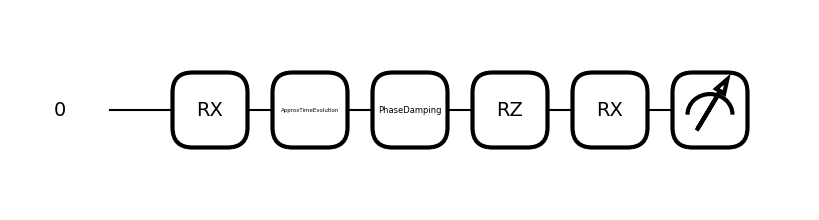

In [5]:
fig, ax = qml.draw_mpl(circuit)(1)

In [6]:
@qml.qnode(dev, interface='torch', diff_method='backprop')
def Post_selection(phi):
    """ 
    Perform post-selection on the output of the `circuit` function.

    Args:
        phi (torch.Tensor): Phase angle for the quantum gate.

    Returns:
        torch.Tensor: Post-selected density matrix after applying a Kraus operator.
    """
    global Paras_global, Gamma_ps_global
    get_density_matrix = circuit(phi)
        
    # Kraus operator for 2*2 matrix
    K = torch.tensor([
        [torch.sqrt(1 - Gamma_ps_global), 0],
        [0, 1]
    ], dtype=torch.complex128)

    Numerator = K @ get_density_matrix @ K.conj().T
    Denominator = torch.trace(Numerator)
    rho_ps = Numerator / Denominator

    qml.QubitDensityMatrix(rho_ps, wires = 0)
    
    return qml.density_matrix(wires = 0) 

### Post-selection for Single-qubit Circuit 
The `Post_selection(phi)` function encapsulates the process of post-selection within a quantum circuit.

### Implementation details

- Quantum Circuit Execution
: We call the function `circuit(phi)`, which returns the density matrix of the system as a complex tensor in PyTorch.

- Kraus operator 
: A Kraus operator `K` is defined to model the noise process or selective measurements

$$
K = \begin{bmatrix}
\sqrt{1 - \gamma_{ps}} & 0 \\
0 & 1
\end{bmatrix}
$$

- Application of Post-selection 
: The post-selection process is modeled by applying the Kraus operator `K` to the system's density matrix `ρ`, and normalizing the result by the trace of the numerator to obtain the post-selected density matrix 
ρ_ps

$$
\rho_{\text{ps}} = \frac{K \rho K^\dagger}{\text{Tr}{[K \rho K^\dagger]}}

$$

In [7]:
def set_circuit(desired_tau_dephase, desired_gamma_post_selection):
    """
    Set the global dephasing rate and post-selection rate for the circuit.

    Args:
        desired_tau_dephase (float): Desired dephasing rate tau.
        desired_gamma_post_selection (float): Desired post-selection rate gamma.
    """
    global Tau_global, Gamma_ps_global 
    
    Tau_global = torch.tensor(desired_tau_dephase)
    Gamma_ps_global = torch.tensor([desired_gamma_post_selection])

In [8]:
def cost_function(paras):
    """ 
    Compute the cost using classical Fisher information for the given parameters.

    Args:
        paras (torch.Tensor): Parameters for quantum gates.

    Returns:
        torch.Tensor: Computed cost.
    """
    global Paras_global, Phi_global
    Paras_global = paras

    CFI = qml.qinfo.classical_fisher(Post_selection)(Phi_global)

    return -CFI

### Cost-function to Maximize
The function cost_function(paras) is specifically designed to compute the Classical Fisher Information (CFI) with respect to a set of parameters. The CFI is an important quantity in quantum parameter estimation and is given by the formula:

$$
\text{CFI}(\theta) = \sum_{x} \frac{1}{P(x|\theta)} \left( \frac{\partial P(x|\theta)}{\partial \theta} \right)^2
$$

#### `qml.qinfo.classical_fisher`
The function `qml.qinfo.classical_fisher` within the PennyLane library computes the CFI for the supplied parameters. By invoking this function with a quantum circuit's parameters, it yields a matrix whose size is proportional to the number of parameters involved. However, in our specific application, we focus on the time-evolution parameter `phi_global` instead of local variables. This strategic choice is driven by the goal to assess the CFI with respect to time-evolution only.

Using global variables like `phi_global` allows us to selectively compute the CFI for this singular, crucial parameter, bypassing the necessity to evaluate a potentially large parameter space. This approach streamlines the computation, focusing our resources and optimization efforts on the time-evolution aspect.

To gain a deeper understanding of how `qml.qinfo.classical_fisher` is implemented and its functionalities, you can refer to the official PennyLane documentation at:
https://docs.pennylane.ai/en/latest/code/api/pennylane.qinfo.transforms.classical\_fisher.html

#### (-) sign
The purpose is to amplify the CFI, thereby enhancing the precision of parameter estimation. Given that PyTorch optimizers inherently minimize cost functions, the CFI's sign is inverted in the return statement of our cost_function.

In [9]:
def plot_test():
    global Paras_global
    # set circuit
    set_circuit(0, 0.8)
    Paras_global = torch.tensor([torch.pi/2, torch.pi/2])
    
    PHI = torch.arange(0, 3*torch.pi, 1e-1)
    Data_temp = torch.zeros((len(PHI), 2))
    Data_temp[:, 0] = PHI

    for idx, phi_current in enumerate(PHI):
        phi_temp = torch.tensor([phi_current])
        Data_temp[idx][1] = qml.qinfo.classical_fisher(Post_selection)(phi_temp)

    Data_temp = Data_temp.detach().numpy() 
    
    plt.plot(Data_temp[:,0], Data_temp[:,1], label = f'$\gamma$ = {Gamma_ps_global}')

    plt.title('CFI by selected gamma')
    plt.xlabel('Time')
    plt.ylabel('CFI')
    plt.legend()
    plt.grid()
    
# plot_test()

In [10]:
def primative():
    params_t = torch.tensor([1.0, torch.pi/2], requires_grad=True)

    Circuit_select_global = Post_selection
    Phi_global = torch.tensor([torch.pi*2])

    # opt = torch.optim.LBFGS([params_t])
    # opt = torch.optim.Adam([params_t])
    opt = torch.optim.LBFGS(
        [params_t], 
        lr=0.01,              # Learning rate
        max_iter=20,          # Maximum number of iterations per optimization step
        max_eval=None,        # Maximum number of function evaluations per optimization step
        tolerance_grad=1e-7,  # Termination tolerance on the gradient norm
        tolerance_change=1e-9,# Termination tolerance on the function value/parameter changes
        history_size=100      # Update history size
    )

    steps = 500

    f_logs = [cost_function(params_t).item()]
    ftol = 1e-10

    def closure():
        opt.zero_grad()
        loss = cost_function(params_t)
        loss.backward()
        return loss

    for i in range(steps):
        opt.step(closure)
        fval = cost_function(opt.param_groups[0]['params'][0]).item()
        print(f"{i+1:03d}th iteration, CFI=", fval)
        f_logs.append(fval)
        if np.abs((fval-f_logs[-2])/fval) < ftol:
            break
        
    print("CFI=", fval, "Paras=", opt.param_groups[0]['params'][0].detach().numpy())
    
# primative()

In [11]:
def torch_optimization(sweep_range, initial_parameters, method):
    """ 
    Perform optimization using specified optimizer over a range of phi values.

    Args:
        sweep_range (list): Range of phi values for optimization.
        initial_parameters (torch.Tensor): Initial parameters for optimization.
        method (str): Optimization method ('LBFGS' or 'Adam').

    Returns:
        torch.Tensor: Data tensor containing optimization results.
    """
    Phi = torch.arange(sweep_range[0], sweep_range[1], sweep_range[2], dtype=torch.float32)
    Data = torch.zeros((len(Phi), len(initial_parameters) + 2))
    Data[:,0] = Phi
    
    global Phi_global
    params_tensor = initial_parameters.clone().requires_grad_(True)
    
    opt = tr_opt.select_optimizer(method, params_tensor)
    
    def closure():
        opt.zero_grad()
        loss = cost_function(params_tensor)
        loss.backward()
        return loss
       
    steps = 20
    f_logs = [cost_function(params_tensor).item()]
    ftol = 1e-10
        
    # Begin optimization
    for phi_idx in range(len(Phi)):
        Phi_global = Phi[phi_idx].clone().requires_grad_(True)
        # Add extra steps for begging of optimization

        for i in range(steps):
            opt.step(closure)

            fval = cost_function(opt.param_groups[0]['params'][0]).item()
            # print(f"{i+1:03d}th iteration, CFI=", fval)
            f_logs.append(fval)
            if np.abs((fval-f_logs[-2])/fval) < ftol:
                break
            
        formatted_x = [f"{x:.8f}" for x in opt.param_groups[0]['params'][0].detach().numpy()]
        print("CFI =", f"{-fval:.5f}", "Paras =", formatted_x)
        
        Data[phi_idx, 1] = -fval
        Data[phi_idx, 2:] = opt.param_groups[0]['params'][0]
        
        # torch.cat(([-fval], opt.param_groups[0]['params'][0].detach().numpy()))

    return Data

### `torch_optimization`

#### Purpose
The `torch_optimization` function performs optimization over a range of Phi values using the specified optimization method ('LBFGS' or 'Adam'). The function iteratively optimizes the quantum gate parameters, aiming to minimize a predefined cost function.

#### Arguments

- `sweep_range` (list): A list specifying the start, end, and step values to generate a range of ϕ values for optimization.
- `initial_parameters` (torch.Tensor): A tensor containing the initial guess for the parameters that will be optimized.
- `method` (str): A string indicating the optimization algorithm to be used ('LBFGS' or 'Adam').

#### Returns:
- `torch.Tensor`: A 2-dimensional tensor containing the optimized results. The first column holds the time-evolution values from `sweep_range`, the second column stores - the optimized parameter θ_x, and the third column contains the optimized parameter ϕ_z.

#### Data structure
The function generates a 2-dimensional torch tensor Data to store the results:
- `Data[:,0]`: stores the Phi values (time of time-evolution) obtained from `sweep_range`.
- `Data[:,1]`: stores the optimized value of the cost function (e.g., negative Classical Fisher Information (CFI)).
- `Data[:,2:]`: stores the optimized parameters of the quantum gate (`theta_x` and `phi_z`).

#### Execution process
1. The function computes a tensor Phi to hold the range of phase values.

2. A zero-initialized tensor Data is prepared to store the optimization results. 

3. For each value of ϕ in Phi, the function performs the optimization using the provided method, updating the global variable `Phi_global`.

4. The optimized parameters and corresponding cost function values are recorded in Data.

### `select_optimizer`

#### Purpose
The select_optimizer function selects and configures a PyTorch optimizer based on the specified method ('LBFGS' or 'Adam').

#### Arguments
- `method`: 
- `parameters_in`:

#### Available Optimizers
- LBFGS: This is an optimization algorithm in the family of quasi-Newton methods. It approximates the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm using a limited amount of computer memory. 

https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html

- Adam: A stochastic optimization method that computes adaptive learning rates for each parameter.

https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

In [12]:
def optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_post_selection, method):
    """ 
    Iterate over different values of tau_dephase and gamma_post_selection for optimization.

    Args:
        sweep_range (list): Range of phi values for optimization.
        init_par (torch.Tensor): Initial parameters for optimization.
        tau_dephase (list): List of dephasing rates tau to iterate over.
        gamma_post_selection (float): Post-selection rate gamma.
        method (str): Optimization method.

    Returns:
        np.ndarray: Numpy array with optimization results for each tau.
    """
    for tau_idx, tau_current in enumerate(tau_dephase):
        set_circuit(tau_current, gamma_post_selection)
        
        temp = torch_optimization(sweep_range, init_par, method).detach().cpu().numpy()
        if tau_idx == 0:
            Data = np.zeros((len(tau_dephase), len(temp[:,0]), len(temp[0,:])))
            Data[tau_idx][:, :] = temp
        else:
            Data[tau_idx][:, :] = temp
            
    return Data

In [13]:
sweep_range = torch.tensor([0.0, 3*torch.pi, 1e-2], dtype=torch.float, requires_grad=False)
init_par = torch.tensor([torch.pi/2, torch.pi/2], dtype=torch.float)
tau_dephase = 0, 5e-3, 5e-2, 1e-1, 5e-1, 1
gamma_ps = 0

res = optimization_by_tau(sweep_range, init_par, tau_dephase, gamma_ps, 'LBFGS')

CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']


CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079637', '1.57079637']
CFI = 1.00000 Paras = ['1.57079

KeyboardInterrupt: 

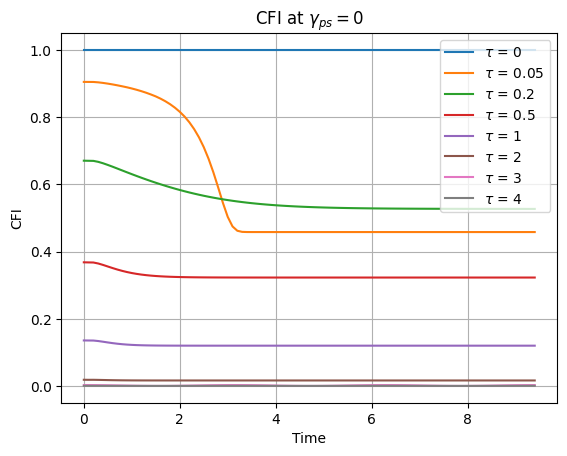

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'CFI')

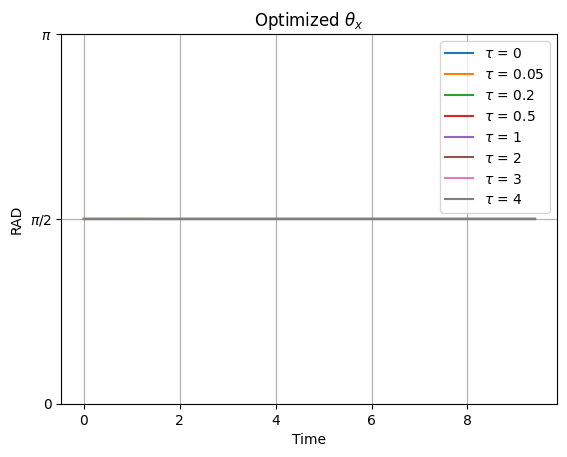

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'theta_x')

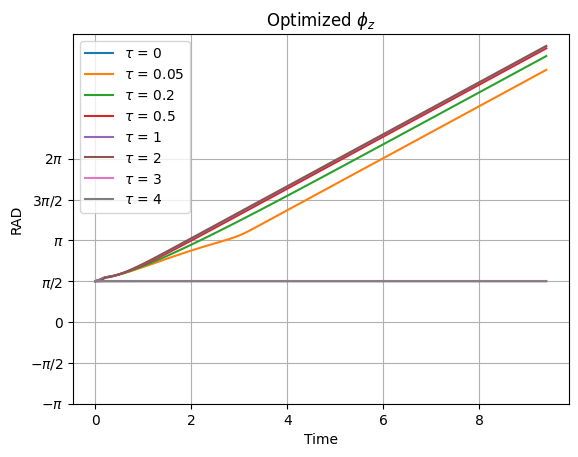

In [ ]:
pt.plot_result(res, tau_dephase, gamma_ps, 'phi_z')

In [ ]:
print (torch.__version__) 
print(torch.backends.mps.is_built()) 
print(torch.backends.mps.is_available())
!python -c 'import platform;print(platform.platform())'

2.0.1
True
True
macOS-14.1-arm64-arm-64bit
